# Toolwindow Usage Analysis - Walkthrough

This notebook reconstructs toolwindow **open -> close** episodes, computes durations,
and compares usage patterns between **manual** and **automatic** opens.
## The analysis includes: ##
- Data cleaning & sanity checks (matching opens/closes, handling orphan events).
- Episode reconstruction (greedy pairing: implicit closes on consecutive opens).
- Summary statistics (counts, means/medians, percentiles) for `manual` vs `auto`.
- Visualizations: ECDF, weekday trends, per-user session counts, and correlations.

Run the notebook from top to bottom.


# Prerequisites
Make sure the data file `toolwindow_events.csv` is in the same directory as this notebook.


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

In [30]:
TIMEOUT = 3600 * 2 # 2 hours

In [31]:
df = pd.read_csv('toolwindow_data.csv')
df['ts'] = pd.to_datetime(df['timestamp'], unit='ms')
df.sort_values(by=['user_id', 'ts'], inplace=True)

In [32]:
episodes = []
orphaned_closes = 0
dataset_end = df['ts'].max()

# Filter Data
We transform the raw data to focus on relevant events. We assume that a double `open` without an intervening `close` implies the first session was closed implicitly. A `close` without a prior `open` is orphaned and discarded.

In [33]:
for user, g in df.groupby('user_id'):
    state = None
    for _, row in g.iterrows():
        if row['event'] == 'opened':
            if not state:
                state = {
                    'user_id': user,
                    'open_ts': row['ts'],
                    'open_type': row['open_type']
                }
            else:
                implicit_close_ts = row['ts']
                duration = (implicit_close_ts - state['open_ts']).total_seconds()
                episodes.append({
                    'user_id': user,
                    'open_ts': state['open_ts'],
                    'close_ts': implicit_close_ts,
                    'duration_s': duration,
                    'open_type': state['open_type'],
                    'censored': False,
                    'note': 'implicit_close_on_new_open'
                })
                state = {
                    'user_id': user,
                    'open_ts': row['ts'],
                    'open_type': row['open_type']
                }
        elif row['event'] == 'closed':
            if not state:
                orphaned_closes += 1
                continue
            close_ts = row['ts']
            duration = (close_ts - state['open_ts']).total_seconds()
            episodes.append({
                'user_id': user,
                'open_ts': state['open_ts'],
                'close_ts': close_ts,
                'duration_s': duration,
                'open_type': state['open_type'],
                'censored': False,
                'note': 'normal_close'
            })
            state = None
    if state:
        duration = (dataset_end - state['open_ts']).total_seconds()
        episodes.append({
            'user_id': user,
            'open_ts': state['open_ts'],
            'close_ts': dataset_end,
            'duration_s': duration,
            'open_type': state['open_type'],
            'censored': True,
            'note': 'implicit_close_on_end'
        })

In [34]:
episodes_df = pd.DataFrame(episodes)
episodes_df['duration_min'] = episodes_df['duration_s'] / 60.0

In [35]:
print(f'Total episodes: {len(episodes_df)}')
print(episodes_df.head())

Total episodes: 1865
   user_id                 open_ts                close_ts  duration_s  \
0        1 2025-07-06 18:21:42.123 2025-07-06 18:32:26.077     643.954   
1        1 2025-07-06 22:34:18.635 2025-07-07 00:52:24.609    8285.974   
2        1 2025-07-08 14:38:07.772 2025-07-08 14:57:03.885    1136.113   
3        1 2025-07-11 16:10:04.033 2025-07-11 16:10:04.781       0.748   
4        1 2025-07-11 16:10:05.587 2025-07-11 18:10:32.775    7227.188   

  open_type  censored          note  duration_min  
0      auto     False  normal_close     10.732567  
1    manual     False  normal_close    138.099567  
2    manual     False  normal_close     18.935217  
3    manual     False  normal_close      0.012467  
4    manual     False  normal_close    120.453133  


In [36]:
print(f'Orphaned closes: {orphaned_closes}')
print(episodes_df['note'].value_counts())

Orphaned closes: 16
note
normal_close                  1622
implicit_close_on_new_open     209
implicit_close_on_end           34
Name: count, dtype: int64


In [37]:
total_normal_events = episodes_df['note'].value_counts()['normal_close']
total_implicit_close_on_new_open = episodes_df['note'].value_counts()['implicit_close_on_new_open']
total_implicit_close_on_end = episodes_df['note'].value_counts()['implicit_close_on_end']
total_counted_events = (total_normal_events * 2 + total_implicit_close_on_new_open + total_implicit_close_on_end + orphaned_closes)

assert total_counted_events == len(df), "Event counts do not match!"

In [38]:
episodes_df = episodes_df[episodes_df['censored'] == False]


### Total Actions Summary
We calculate how many tool window sessions were detected in total and how many were opened **manually vs automatically**.  
**What we learn:** This helps establish the baseline, are users mostly opening the tool window themselves, or is it triggered automatically more often?


In [39]:
total_actions = len(episodes_df)
total_manual = (episodes_df['open_type'] == 'manual').sum()
total_auto = (episodes_df['open_type'] == 'auto').sum()
print(f'Total actions: {total_actions}')
print(f'Total manual opens: {total_manual}')
print(f'Total auto opens: {total_auto}')

Total actions: 1831
Total manual opens: 651
Total auto opens: 1180


We find out that there are a lot more automatic opens than manual ones, indicating that the tool window is often triggered by the system rather than user action.


### Average Duration (All vs Manual vs Auto)
We compute the **mean open duration** across all sessions and compare manual vs auto opens.  
**What we learn:** This shows whether manually opened tool windows tend to stay open longer, possibly indicating more deliberate use.


In [40]:
avg_duration_s = episodes_df['duration_s'].mean()
avg_manual_duration_s = episodes_df[episodes_df['open_type'] == 'manual']['duration_s'].mean()
avg_auto_duration_s = episodes_df[episodes_df['open_type'] == 'auto']['duration_s'].mean()
print(f'Average duration (s): {avg_duration_s:.2f}')
print(f'Average manual duration (s): {avg_manual_duration_s:.2f}')
print(f'Average auto duration (s): {avg_auto_duration_s:.2f}')

Average duration (s): 12905.09
Average manual duration (s): 4640.45
Average auto duration (s): 17464.65



### Average Duration Under Threshold
We analyze short sessions (≤ threshold seconds).  
**What we learn:** These just filter out long sessions that might skew averages.


In [41]:
under = episodes_df[episodes_df['duration_s'] <= TIMEOUT]
avg_under_all = under['duration_s'].mean()
avg_under_manual = under[under['open_type'] == 'manual']['duration_s'].mean()
avg_under_auto = under[under['open_type'] == 'auto']['duration_s'].mean()
print(f'Average duration under {TIMEOUT}s ({TIMEOUT / 3600}h) (all): {avg_under_all:.2f}s ({avg_under_all / 3600:.2f}h)')
print(f'Average duration under {TIMEOUT}s ({TIMEOUT / 3600}h) (manual): {avg_under_manual:.2f}s ({avg_under_manual / 3600:.2f}h)')
print(f'Average duration under {TIMEOUT}s ({TIMEOUT / 3600}h) (auto): {avg_under_auto:.2f}s ({avg_under_auto / 3600:.2f}h)')

Average duration under 7200s (2.0h) (all): 536.96s (0.15h)
Average duration under 7200s (2.0h) (manual): 246.24s (0.07h)
Average duration under 7200s (2.0h) (auto): 721.91s (0.20h)


The window is kept open for longer when opened automatically, suggesting that automatic opens may be more contextually relevant. It could also indicate that users who manually open the tool know what they want and close it quickly while automatic opens may require more exploration.


### Average Duration Over Threshold
We analyze long sessions (> threshold seconds).  
**What we learn:** These are likely left open unintentionally or when users are away.


In [42]:
over = episodes_df[episodes_df['duration_s'] > TIMEOUT]
avg_over_all = over['duration_s'].mean()
avg_over_manual = over[over['open_type'] == 'manual']['duration_s'].mean()
avg_over_auto = over[over['open_type'] == 'auto']['duration_s'].mean()
print(f'Average duration over {TIMEOUT}s ({TIMEOUT / 3600}h) (all): {avg_over_all:.2f}s ({avg_over_all / 3600:.2f}h)')
print(f'Average duration over {TIMEOUT}s ({TIMEOUT / 3600}h) (manual): {avg_over_manual:.2f}s ({avg_over_manual / 3600:.2f}h)')
print(f'Average duration over {TIMEOUT}s ({TIMEOUT / 3600}h) (auto): {avg_over_auto:.2f}s ({avg_over_auto / 3600:.2f}h)')

Average duration over 7200s (2.0h) (all): 95290.33s (26.47h)
Average duration over 7200s (2.0h) (manual): 89640.98s (24.90h)
Average duration over 7200s (2.0h) (auto): 96163.65s (26.71h)


In [43]:
print(f'Episodes over {TIMEOUT}s ({TIMEOUT / 3600}h): {len(over)} ({len(over) / len(episodes_df) * 100:.2f}%)')
print(f'Episodes under {TIMEOUT}s ({TIMEOUT / 3600}h): {len(under)} ({len(under) / len(episodes_df) * 100:.2f}%)')

Episodes over 7200s (2.0h): 239 (13.05%)
Episodes under 7200s (2.0h): 1592 (86.95%)


In [44]:
def plot_ecdf(data, label=None):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    plt.step(x, y, where='post', label=label)


### ECDF of Durations
We plot the **Empirical Cumulative Distribution Function (ECDF)** for all, manual, and auto sessions.  
**What we learn:** The ECDF shows how quickly sessions accumulate, steeper curves indicate shorter, more uniform sessions.


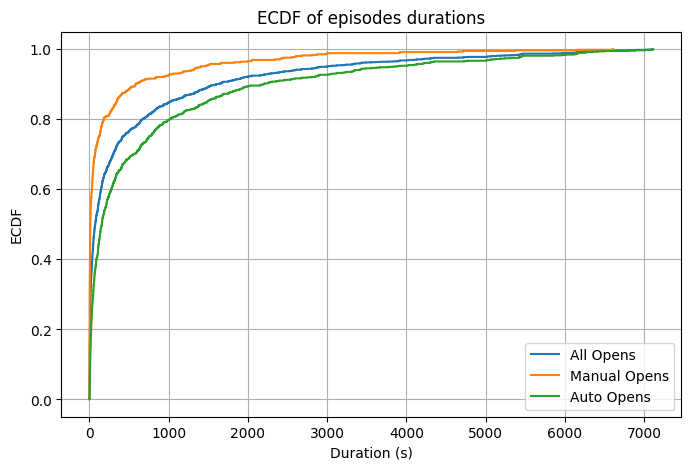

In [45]:
plt.figure(figsize=(8, 5))
plot_ecdf(under['duration_s'], label='All Opens')
plot_ecdf(under[under['open_type'] == 'manual']['duration_s'], label='Manual Opens')
plot_ecdf(under[under['open_type'] == 'auto']['duration_s'], label='Auto Opens')
plt.xlabel('Duration (s)')
plt.ylabel('ECDF')
plt.title('ECDF of episodes durations')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
overall_pct = (under['duration_s'] < 1000).mean() * 100
by_type_pct = under.groupby('open_type')['duration_s'].apply(lambda s: (s < 1000).mean() * 100).reset_index(name='percentile')

print(f'{overall_pct:.1f}% of events are shorter than 1000s.')
for _, r in by_type_pct.iterrows():
    print(f'{r.open_type.capitalize()} opens: {r.percentile:.1f}% shorter than 1000s.')

84.8% of events are shorter than 1000s.
Auto opens: 79.9% shorter than 1000s.
Manual opens: 92.6% shorter than 1000s.



### Actions per Weekday
We visualize how many tool window actions occur each day of the week.  
**What we learn:** Patterns like weekday peaks suggest work-related tool usage; weekend activity might show personal projects or extended work habits.


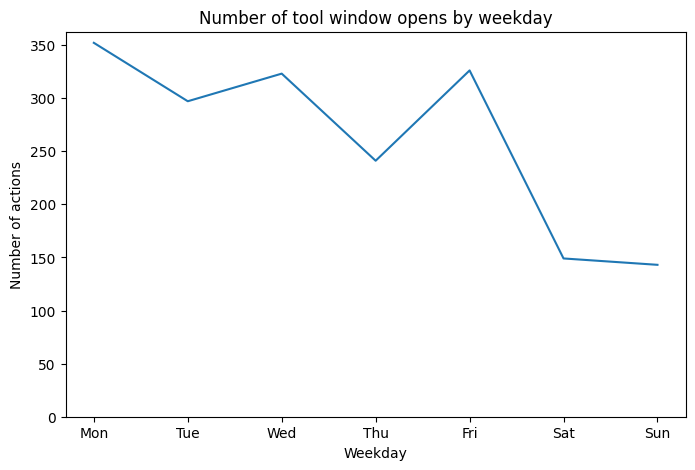

In [ ]:
episodes_df['weekday'] = episodes_df['open_ts'].dt.weekday
weekday_counts = episodes_df.groupby('weekday').size()
plt.figure(figsize=(8, 5))
plt.plot(weekday_counts.index, weekday_counts.values)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylim(0)
plt.xlabel('Weekday')
plt.ylabel('Number of actions')
plt.title('Number of tool window opens by weekday')
plt.show()


### Average Duration per Weekday
We compute and plot the average duration by weekday.  
**What we learn:** This helps see if users engage differently across the week, for instance, shorter sessions mid-week vs longer ones on weekends.


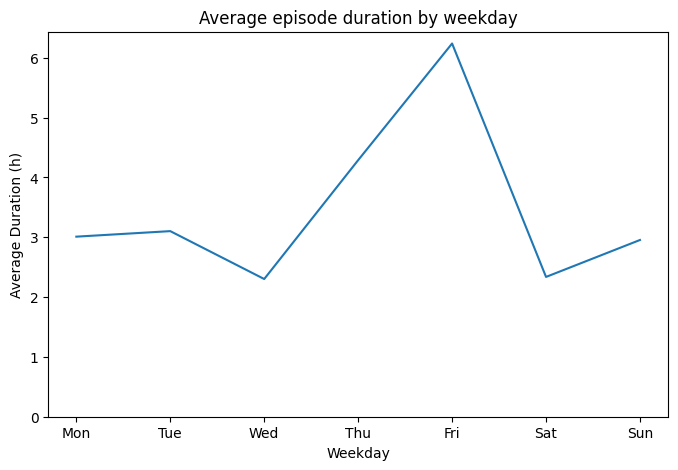

In [ ]:
weekday_avg = episodes_df.groupby('weekday')['duration_s'].mean() / 3600
plt.figure(figsize=(8, 5))
plt.plot(weekday_avg.index, weekday_avg.values)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylim(0)
plt.xlabel('Weekday')
plt.ylabel('Average Duration (h)')
plt.title('Average episode duration by weekday')
plt.show()


### Session Counts Average per User
We compute the average number of sessions each user performed.  
**What we learn:** This indicates how frequently users interact with the tool window on average.


In [ ]:
session_counts = episodes_df.groupby('user_id').size()
print(f'Average sessions per user: {session_counts.mean():.2f}')

Average sessions per user: 9.15



### Session Counts per User
We compute how many sessions each user performed.  
**What we learn:** This reveals that some users may use the feature heavily while others rarely interact with it.


In [ ]:
print(f'Session counts per user (top 5):')
print(session_counts.sort_values(ascending=False).head(5))

print(f'Session counts per user (bottom 5):')
print(session_counts.sort_values(ascending=True).head(5))

Session counts per user (top 5):
user_id
15    94
12    83
10    80
25    70
28    64
dtype: int64
Session counts per user (bottom 5):
user_id
100    1
153    1
148    1
146    1
144    1
dtype: int64


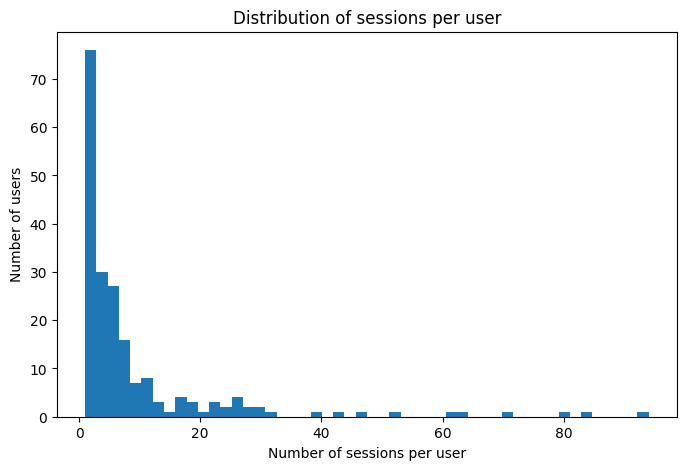

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(session_counts.values, bins=50)
plt.xlabel('Number of sessions per user')
plt.ylabel('Number of users')
plt.title('Distribution of sessions per user')
plt.show()


### Open Frequency vs Median Duration
We compare each user’s total session frequency with their median session duration and calculate correlation metrics.  
**What we learn:** A negative correlation would suggest that frequent users open the tool more often but for shorter periods.


In [ ]:
per_user = under.groupby('user_id').agg(
    frequency = ('duration_s', 'size'),
    median_duration_s = ('duration_s', 'median')
).reset_index()
print('Per user frequency and median duration (top 5):')
print(per_user.sort_values(by='frequency', ascending=False).head(5))

Per user frequency and median duration (top 5):
    user_id  frequency  median_duration_s
14       15         92           119.1925
9        10         76           210.2255
11       12         72           111.5900
21       22         60           128.5665
24       25         57           275.6120


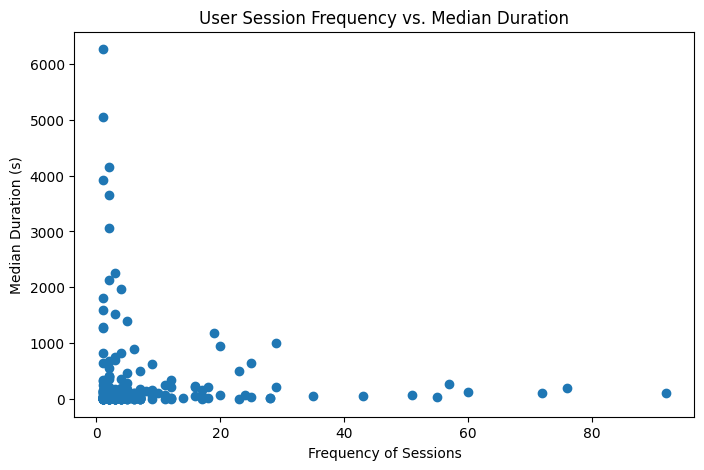

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(per_user['frequency'], per_user['median_duration_s'])
plt.xlabel('Frequency of Sessions')
plt.ylabel('Median Duration (s)')
plt.title('User Session Frequency vs. Median Duration')
plt.show()

In [ ]:
spearman_corr, p_value = spearmanr(per_user['frequency'], per_user['median_duration_s'])
print(f'Spearman correlation between frequency and median duration: {spearman_corr:.4f} (p-value: {p_value:.4f})')

Spearman correlation between frequency and median duration: 0.0748 (p-value: 0.2973)


### Unfortunately, We see no significant correlation in either direction.